<a href="https://colab.research.google.com/github/noorulghousiah/Classification-of-Rosa-Genus-Species/blob/main/DeepLearning_PlantClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0) GPU Settings**

In [ ]:
%matplotlib inline

In [ ]:
!nvidia-smi

Tue Jun 10 00:22:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# **1) Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

csv_path = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/Project/PlantCLEF2024singleplanttrainingdata.csv'

# Load the CSV with semicolon delimiter and without assuming column names
df = pd.read_csv(csv_path, sep=';', header=0, low_memory=False)

# Show the shape and first few rows
print(f"Shape: {df.shape}")
df.head()

Shape: (1408033, 20)


,image_name,organ,species_id,obs_id,license,partner,author,altitude,latitude,longitude,gbif_species_id,species,genus,family,dataset,publisher,references,url,learn_tag,image_backup_url
0,59feabe1c98f06e7f819f73c8246bd8f1a89556b.jpg,leaf,1396710,1008726402,cc-by-sa,NaN,Gulyás Bálint,205.9261,47.592160,19.362895,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/59feabe1c98f06...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
1,dc273995a89827437d447f29a52ccac86f65476e.jpg,leaf,1396710,1008724195,cc-by-sa,NaN,vadim sigaud,323.7520,47.906703,7.201746,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/dc273995a89827...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
2,416235e7023a4bd1513edf036b6097efc693a304.jpg,leaf,1396710,1008721908,cc-by-sa,NaN,fil escande,101.3160,48.826774,2.352774,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/416235e7023a4b...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
3,cbd18fade82c46a5c725f1f3d982174895158afc.jpg,leaf,1396710,1008699177,cc-by-sa,NaN,Desiree Verver,5.1070,52.190427,6.009677,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/cbd18fade82c46...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
4,f82c8c6d570287ebed8407cefcfcb2a51eaaf56e.jpg,leaf,1396710,1008683100,cc-by-sa,NaN,branebrane,165.3390,45.794739,15.965862,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/f82c8c6d570287...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...


In [ ]:
!pip install --quiet pillow requests


In [ ]:
df.columns


Index(['image_name', 'organ', 'species_id', 'obs_id', 'license', 'partner',
       'author', 'altitude', 'latitude', 'longitude', 'gbif_species_id',
       'species', 'genus', 'family', 'dataset', 'publisher', 'references',
       'url', 'learn_tag', 'image_backup_url'],
      dtype='object')

In [ ]:
# List unique plant families
print(df['family'].unique())

['Taxaceae' 'Polypodiaceae' 'Papaveraceae' 'Rosaceae' 'Caryophyllaceae'
 'Polygonaceae' 'Salicaceae' 'Lamiaceae' 'Ranunculaceae' 'Fabaceae'
 'Anacardiaceae' 'Solanaceae' 'Primulaceae' 'Cyperaceae' 'Bignoniaceae'
 'Fagaceae' 'Oleaceae' 'Viburnaceae' 'Asteraceae' 'Elaeagnaceae'
 'Apiaceae' 'Plantaginaceae' 'Scrophulariaceae' 'Sarraceniaceae' 'Poaceae'
 'Tamaricaceae' 'Liliaceae' 'Pinaceae' 'Brassicaceae' 'Asparagaceae'
 'Orchidaceae' 'Ericaceae' 'Cactaceae' 'Caprifoliaceae' 'Malvaceae'
 'Crassulaceae' 'Rubiaceae' 'Dennstaedtiaceae' 'Colchicaceae'
 'Amaranthaceae' 'Resedaceae' 'Juglandaceae' 'Rhamnaceae' 'Rutaceae'
 'Aizoaceae' 'Saxifragaceae' 'Grossulariaceae' 'Amaryllidaceae'
 'Saururaceae' 'Gentianaceae' 'Salviniaceae' 'Boraginaceae' 'Cupressaceae'
 'Orobanchaceae' 'Violaceae' 'Cistaceae' 'Urticaceae' 'Gesneriaceae'
 'Potamogetonaceae' 'Pteridaceae' 'Euphorbiaceae' 'Iridaceae'
 'Psilotaceae' 'Linaceae' 'Plumbaginaceae' 'Alismataceae'
 'Aristolochiaceae' 'Hymenophyllaceae' 'Asphodelacea

In [ ]:
# Count number of images per family
print(df['family'].value_counts())

family
Asteraceae          176707
Fabaceae            101605
Poaceae              83556
Rosaceae             68573
Brassicaceae         56413
                     ...  
Scheuchzeriaceae       215
Psilotaceae            206
Saururaceae            185
Drosophyllaceae        154
Cyatheaceae            112
Name: count, Length: 181, dtype: int64


In [ ]:
# Filter for a specific family
filtered_df = df[df['genus'] == 'Rosa'].reset_index(drop=True)

# Check the result
print(f"Filtered shape: {filtered_df.shape}")
filtered_df.head()

Filtered shape: (9345, 20)


,image_name,organ,species_id,obs_id,license,partner,author,altitude,latitude,longitude,gbif_species_id,species,genus,family,dataset,publisher,references,url,learn_tag,image_backup_url
0,7eef0e09494d8d296d3955c201df96fe44b2ec24.jpg,flower,1360335,1018140105,cc-by-sa,NaN,jf rm,510.856,43.929252,3.051430,3007783.0,Rosa corymbifera Borkh.,Rosa,Rosaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/7eef0e09494d8d...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
1,e1cd3634af95d6390943fced1e091267465daeb6.jpg,flower,1360335,1006255994,cc-by-sa,NaN,Christophe Romanowski,112.000,48.037020,3.319346,3007783.0,Rosa corymbifera Borkh.,Rosa,Rosaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/e1cd3634af95d6...,val,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
2,3a3634a843ac8ad9a7baef50ed2e8101664588f1.jpg,flower,1360335,1018759296,cc-by-sa,NaN,Clara Courtaut,NaN,NaN,NaN,3007783.0,Rosa corymbifera Borkh.,Rosa,Rosaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/3a3634a843ac8a...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
3,14eeb1f2f1eb5b831db99600914ed5319ddefbac.jpg,flower,1360335,1018572587,cc-by-sa,NaN,Matrox,281.000,57.059662,-3.069822,3007783.0,Rosa corymbifera Borkh.,Rosa,Rosaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/14eeb1f2f1eb5b...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
4,a22425e46a777fe0935116f3780b848375d451b7.jpg,flower,1360335,1018112013,cc-by-sa,NaN,Frank Olfers,63.000,53.176479,8.653401,3007783.0,Rosa corymbifera Borkh.,Rosa,Rosaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/a22425e46a777f...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import requests
from io import BytesIO


class PlantClefDataset(Dataset):
    def __init__(self, csv_path=None, df=None, transform=None, mode='train'):
        # Load data from DataFrame if provided, else load from CSV
        if df is not None:
            self.df = df.copy()
        elif csv_path:
            self.df = pd.read_csv(csv_path, sep=';', header=0, low_memory=False)
        else:
            raise ValueError("Either csv_path or df must be provided.")

        # Filter by mode: 'train' or 'test'
        self.df = self.df[self.df['learn_tag'] == mode].reset_index(drop=True)

        # Drop rows without image URL or species label
        self.df = self.df.dropna(subset=['image_backup_url', 'species'])

        self.transform = transform

        # Encode species labels as integers
        self.label_to_idx = {label: idx for idx, label in enumerate(self.df['species'].unique())}
        self.idx_to_label = {v: k for k, v in self.label_to_idx.items()}
        self.df['label'] = self.df['species'].map(self.label_to_idx)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        url = self.df.loc[idx, 'image_backup_url']
        label = self.df.loc[idx, 'label']

        try:
            response = requests.get(url, timeout=10)
            image = Image.open(BytesIO(response.content)).convert('RGB')
        except:
            # Return a blank image if loading fails
            image = Image.new('RGB', (224, 224), (255, 255, 255))

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


# Load training dataset
train_dataset = PlantClefDataset(df=filtered_df, transform=transform, mode='train')

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)


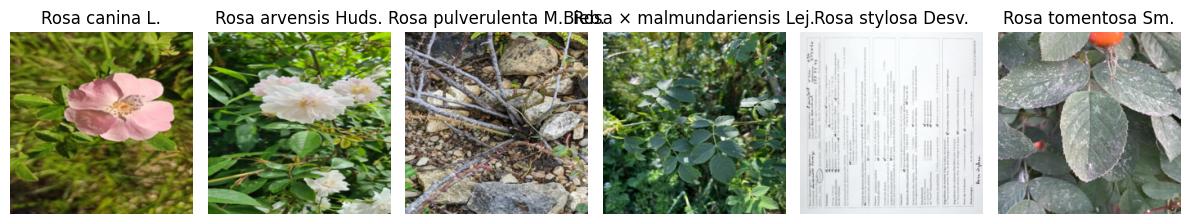

In [ ]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

plt.figure(figsize=(12, 4))
for i in range(6):
    img = images[i].permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = img.clamp(0, 1)
    plt.subplot(1, 6, i+1)
    plt.imshow(img)
    plt.title(train_dataset.idx_to_label[labels[i].item()])
    plt.axis('off')


plt.subplots_adjust(wspace=0.5)  # add spacing between images
plt.tight_layout()
plt.show()

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

def get_dataloader(csv_path, batch_size=32, num_workers=2):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    train_dataset = PlantClefDataset(df=filtered_df, transform=transform, mode='train')
    test_dataset = PlantClefDataset(df=filtered_df, transform=transform, mode='test')

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Assuming your dataset class has an attribute or method to get class names or number of classes
    num_classes = len(train_dataset.label_to_idx)  # or train_dataset.num_classes if defined
    print(f'Number of classes: {num_classes}')

    return train_dataloader, test_dataloader

# Usage
train_dataloader, test_dataloader = get_dataloader(csv_path=csv_path, batch_size=16, num_workers=2)

num_classes = len(train_dataset.label_to_idx)

Number of classes: 39


# **2) Define Training and Validation**

In [ ]:
import time
from tqdm.auto import tqdm
from google.colab import files

def train_and_validate(model, loss_criterion, optimizer, train_dataloader, test_dataloader, epochs=25, device='cuda'):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param train_dataloader: DataLoader for training data
        :param test_dataloader: DataLoader for test/validation data
        :param epochs: Number of epochs (default=25)
        :param device: Device to perform computations ('cuda' or 'cpu')

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    # accuracy = torchmetrics.Accuracy(device=device)
    # Initialize the accuracy metric from torchmetrics
    # accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10).to(device)

    for epoch in tqdm(range(epochs)):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)


        # Find average training loss and training accuracy
        avg_train_loss = train_loss / len(train_dataloader.dataset)
        avg_train_acc = train_acc / len(train_dataloader.dataset)

        # Find average validation loss and training accuracy
        avg_test_loss = valid_loss / len(test_dataloader.dataset)
        avg_test_acc = valid_acc / len(test_dataloader.dataset)

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc * 100, avg_test_loss, avg_test_acc * 100, epoch_end - epoch_start))

        # Save if the model has best accuracy till now
        if avg_test_acc > best_acc:
            best_acc = avg_test_acc
            best_model = model
            torch.save(best_model, 'best_model.pt')



            # Save best model (already done earlier)
            torch.save(best_model, 'best_model.pt')

            # Automatically download to your laptop
            files.download('best_model.pt')

    return best_model, history

# **3) Load a pretrained model**

In [ ]:
#pip install timm torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 56.3/56.3 MB 60.1 MB/s eta 0:00:01
ERROR: Operation cancelled by user


In [ ]:
import torch
import timm
from torchinfo import summary

model_ft = timm.create_model('efficientnet_lite0', pretrained=True, num_classes=num_classes)

model_ft.to(device)
model_ft


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequent

In [ ]:
model_ft.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft.to(device)


summary(model=model_ft,
        input_size=(1, 3, 224, 224),  # match model expected input size
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                   [1, 3, 518, 518]     [1, 39]              --                   True
├─Conv2d (conv_stem)                          [1, 3, 518, 518]     [1, 32, 259, 259]    864                  True
├─BatchNormAct2d (bn1)                        [1, 32, 259, 259]    [1, 32, 259, 259]    64                   True
│    └─Identity (drop)                        [1, 32, 259, 259]    [1, 32, 259, 259]    --                   --
│    └─ReLU6 (act)                            [1, 32, 259, 259]    [1, 32, 259, 259]    --                   --
├─Sequential (blocks)                         [1, 32, 259, 259]    [1, 320, 17, 17]     --                   True
│    └─Sequential (0)                         [1, 32, 259, 259]    [1, 16, 259, 259]    --                   True
│    │    └─DepthwiseSeparableConv (0)        [1, 32, 259, 259]    [1, 16, 259, 259]   

# **4) Define new Fully-Connected layer**

In [ ]:
# Freeze all layers
for param in model_ft.parameters():
    param.requires_grad = False

# Unfreeze only the classifier head
for param in model_ft.get_classifier().parameters():
    param.requires_grad = True

# **5) Training and Evaluation**

In [ ]:
loss_fn = nn.CrossEntropyLoss()

# Only parameters with requires_grad=True will be updated
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=1e-4)

# move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_ft = model_ft.to(device)

In [ ]:
num_epochs = 5
trained_model, history = train_and_validate(model_ft, loss_fn, optimizer, train_dataloader, test_dataloader, num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/5
Epoch : 000, Training: Loss: 3.6360, Accuracy: 5.7564%, 
		Validation : Loss : 4.1044, Accuracy: 5.9524%, Time: 983.9188s


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch: 2/5
Epoch : 001, Training: Loss: 3.4138, Accuracy: 8.6119%, 
		Validation : Loss : 4.0639, Accuracy: 5.9524%, Time: 801.4063s
Epoch: 3/5
Epoch : 002, Training: Loss: 3.2812, Accuracy: 11.0595%, 
		Validation : Loss : 4.0243, Accuracy: 3.9683%, Time: 803.0594s
Epoch: 4/5
Epoch : 003, Training: Loss: 3.1843, Accuracy: 13.0425%, 
		Validation : Loss : 4.0068, Accuracy: 3.9683%, Time: 814.9809s
Epoch: 5/5
Epoch : 004, Training: Loss: 3.0998, Accuracy: 15.1048%, 
		Validation : Loss : 4.0400, Accuracy: 3.9683%, Time: 808.5141s


In [ ]:
import torch

more_epochs = 10
# Load model
model = torch.load('best_model.pt')
model = model.to(device)  # e.g. device = 'cuda' or 'cpu'

# Make sure required parameters are still trainable
# Freeze all layers
for param in model_ft.parameters():
    param.requires_grad = False

# Unfreeze only the classifier head
for param in model_ft.get_classifier().parameters():
    param.requires_grad = True

# Re-define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Resume training
trained_model, history = train_and_validate(model_ft, loss_fn, optimizer,
                                            train_dataloader, test_dataloader,
                                            epochs=more_epochs, device=device)


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL timm.models.efficientnet.EfficientNet was not an allowed global by default. Please use `torch.serialization.add_safe_globals([EfficientNet])` or the `torch.serialization.safe_globals([EfficientNet])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
#Analyze the loss curve
class_names = list(train_dataset.label_to_idx.keys())

def plot_loss(history):
  history = np.array(history)
  plt.plot(history[:,0:2])
  plt.legend(['Tr Loss', 'Val Loss'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Loss')
  plt.ylim(0,3)
  # plt.savefig('cifar10_loss_curve.png')
  plt.show()

def plot_accuracy(history):
  history = np.array(history)
  plt.plot(history[:,2:4])
  plt.legend(['Tr Accuracy', 'Val Accuracy'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Accuracy')
  plt.ylim(0,1)
  # plt.savefig('cifar10_accuracy_curve.png')
  plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# def plot_confusionMatrix(model, test_dataloader):

#   y_pred = []
#   y_true = []

#   model.to('cpu')

#   # iterate over test data
#   for inputs, labels in test_dataloader:
#           output = model(inputs) # Feed Network

#           output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
#           y_pred.extend(output) # Save Prediction

#           labels = labels.data.cpu().numpy()
#           y_true.extend(labels) # Save Truth

#   # Build confusion matrix
#   cf_matrix = confusion_matrix(y_true, y_pred)
#   df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in class_names],
#                       columns = [i for i in class_names])
#   plt.figure(figsize = (20,10))
#   sn.heatmap(df_cm, annot=True)
#   # plt.savefig('output.png')


import numpy as np

def plot_confusionMatrix(model, test_dataloader):
    y_pred = []
    y_true = []

    model.to('cpu')
    model.eval()

    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        preds = torch.max(torch.exp(outputs), 1)[1].data.cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.data.cpu().numpy())

    cf_matrix = confusion_matrix(y_true, y_pred)

    # Get only the present class indices
    present_classes = np.unique(np.concatenate((y_true, y_pred)))
    present_class_names = [class_names[i] for i in present_classes]

    df_cm = pd.DataFrame(cf_matrix, index=present_class_names, columns=present_class_names)
    plt.figure(figsize=(20, 10))
    sn.heatmap(df_cm, annot=True, fmt='d')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    plt.savefig('output.png')

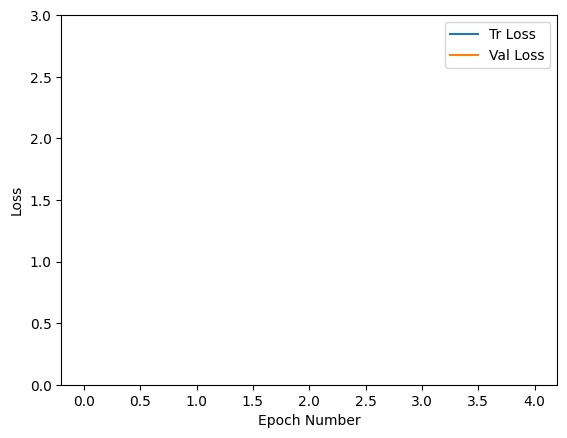

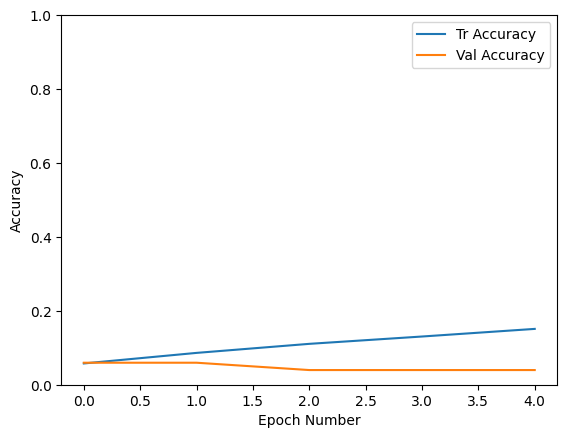

In [ ]:
plot_loss(history)
plot_accuracy(history)

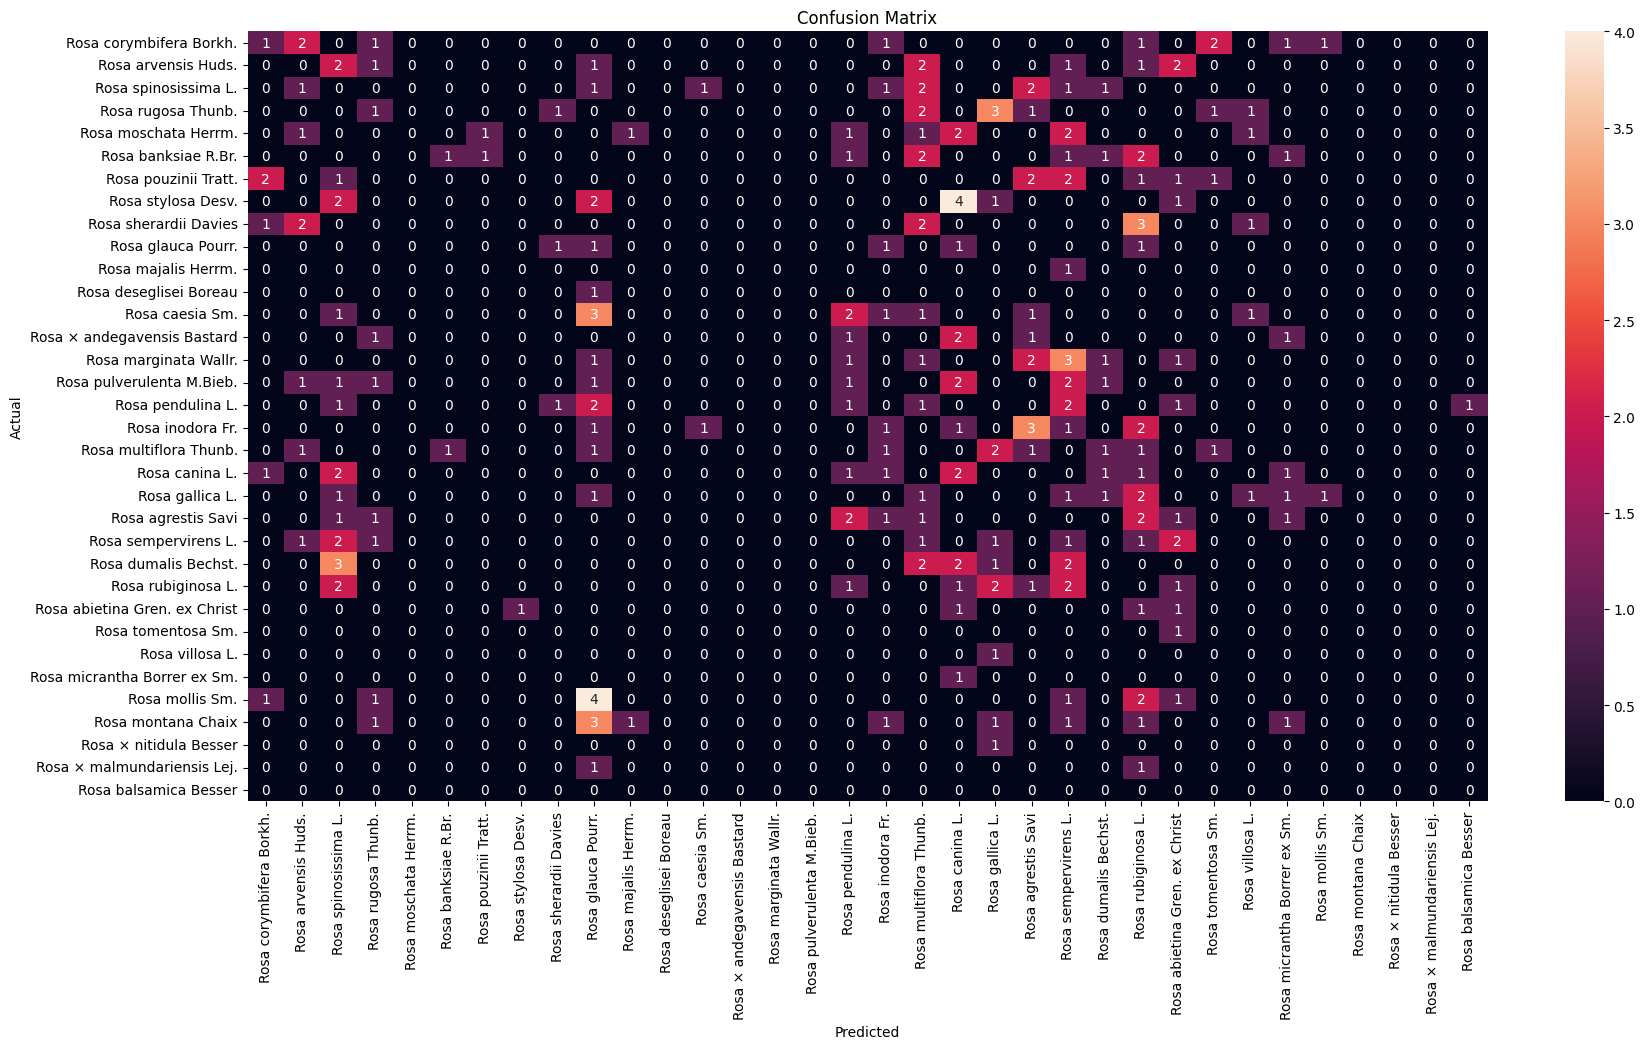

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_confusionMatrix(trained_model, test_dataloader)